# Fire Detection

## Analyzing Single Image

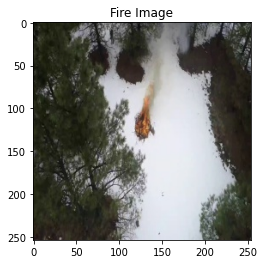

In [14]:
import pandas as pd
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread("data/Training/Fire/resized_frame3.jpg")
plt.imshow(img)
plt.title("Image")
plt.show()

Plot the pixel histogram following: https://datacarpentry.org/image-processing/05-creating-histograms/

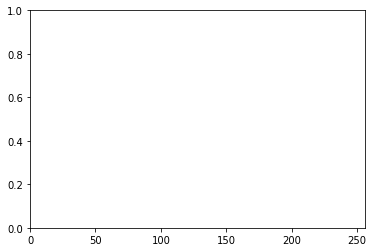

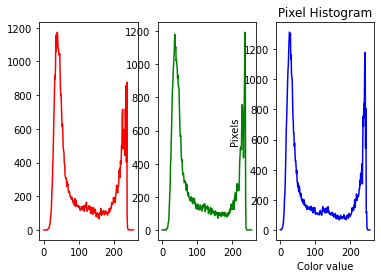

In [35]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

plt.xlim([0, 256])

fig, axes = plt.subplots(1,3)

for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img[:, :, channel_id], bins=256, range=(0, 256)
    )
    axes[channel_id].plot(bin_edges[0:-1], histogram, color=c)
    axes[channel_id].xlabel("Color value")
    axes[channel_id].ylabel("Pixels")
    axes[channel_id].title.set_text("HOLA")


## Transforming Single Image

In [15]:
img_lab = color.rgb2lab(img)

In [16]:
def calculate_mean_channel(img_lab, n):
    channel = img_lab[:,:,n].flatten()
    return np.mean(channel)

In [17]:
l_m = calculate_mean_channel(img_lab, 0)
a_m = calculate_mean_channel(img_lab, 1)
b_m = calculate_mean_channel(img_lab, 2)

print(l_m, a_m, b_m)

43.68792162968718 -1.1012405736707571 3.0390542491519095


In [18]:
def calculate_rx(img_lab, n, m):
    r1 = img_lab[:,:,n] >= m
    return r1 

In [19]:
r1 = calculate_rx(img_lab, 0, l_m) # L >= l_m
r2 = calculate_rx(img_lab, 1, a_m) # A >= a_m
r3 = calculate_rx(img_lab, 2, b_m) # B >= b_m
r4 = calculate_rx(img_lab, 2, img_lab[:,:,1]) # B >= A

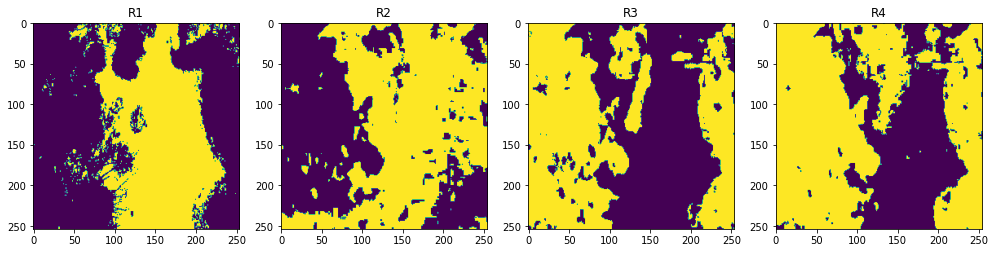

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(17, 17)
ax1.imshow(r1)
ax1.title.set_text("R1")
ax2.imshow(r2)
ax2.title.set_text("R2")
ax3.imshow(r3)
ax3.title.set_text("R3")
ax4.imshow(r4)
ax4.title.set_text("R4")

In [21]:
r_and = np.logical_and(np.logical_and(np.logical_and(r1, r2), r3), r4)

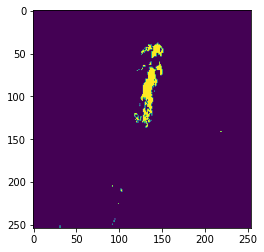

In [22]:
plt.imshow(r_and)

In [23]:
import queue

def clean_small(mat, threshold):
    visited = np.full(mat.shape, False)
    to_remove = []
    cleaned_mat = np.copy(mat)
    q = queue.Queue()
    size = 0

    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if not mat[i,j]:
                continue
            # For each True pixel perfom BFS and calculate size of cluster
            size = 0
            to_remove = []
            q.put((i,j))
            while not q.empty():
                size += 1
                x, y = q.get()
                if (x < len(mat) and x >= 0 and y < len(mat[0]) and y >= 0) and not visited[x,y] and mat[x,y]:
                    visited[x,y] = True
                    to_remove.append((x,y))
                    q.put((x+1, y))
                    q.put((x-1, y))
                    q.put((x, y+1))
                    q.put((x, y-1))
            # If size is smaller than predefined threshold, remove nodes in to_remove
            # print("Report: Size: {} i: {}, j {}".format(size, i, j))
            if size < threshold:
                for x, y in to_remove:
                    cleaned_mat[x,y] = False
    return cleaned_mat


In [24]:
r_cleaned = clean_small(r_and, 20)

In [25]:
def apply_mask(img, mask):
    masked = np.copy(img)
    for i in range(len(masked)):
        for j in range(len(masked[0])):
            masked[i,j] = masked[i,j] if mask[i,j] else [0,0,0]
    
    return masked


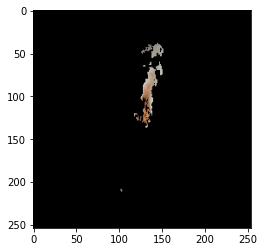

In [26]:
img_masked = apply_mask(img, r_cleaned)
plt.imshow(img_masked)

## Full transformation for an image
Function to transform from a traditional RGB image to the fire pixel detection matrix.

In [27]:

def full_transform(img_rgb, threshold):
    img_lab = color.rgb2lab(img_rgb)
    l_m = calculate_mean_channel(img_lab, 0)
    a_m = calculate_mean_channel(img_lab, 1)
    b_m = calculate_mean_channel(img_lab, 2)

    r1 = calculate_rx(img_lab, 0, l_m)
    r2 = calculate_rx(img_lab, 1, a_m)
    r3 = calculate_rx(img_lab, 2, b_m)
    r4 = calculate_rx(img_lab, 2, img_lab[:,:,1])

    r_and = np.logical_and(np.logical_and(np.logical_and(r1, r2), r3), r4)
    r_cleaned = clean_small(r_and, threshold)

    return apply_mask(img_rgb, r_cleaned)

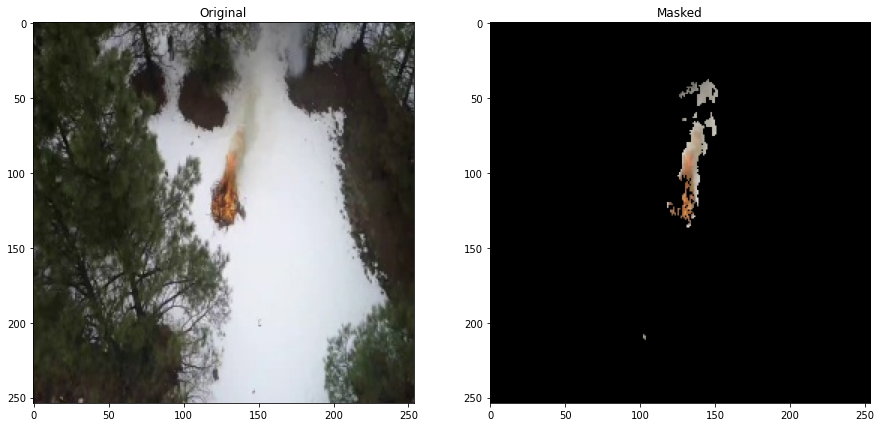

In [32]:
img = io.imread("data/Training/Fire/resized_frame3.jpg")
masked = full_transform(img, 20)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 15)
ax1.imshow(img)
ax1.title.set_text("Original")
ax2.imshow(masked)
ax2.title.set_text("Masked")